In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet('daily_weather.parquet')


In [50]:
stockholm_data = df[df['city_name'] == 'Stockholm']

stockholm_data['date'] = pd.to_datetime(stockholm_data['date'])
stockholm_data['year'] = stockholm_data['date'].dt.year
df_2022 = stockholm_data[stockholm_data['date'].dt.year == 2022]

filtered_df = stockholm_data[['date', 'season','avg_temp_c', 'min_temp_c', 'max_temp_c', 
                              'precipitation_mm', 'avg_wind_dir_deg', 
                              'avg_wind_speed_kmh', 'avg_sea_level_pres_hpa', 
                              'snow_depth_mm']]
# Extraire le mois et le jour à partir de la colonne 'date'
filtered_df['month'] = filtered_df['date'].dt.month
filtered_df['day'] = filtered_df['date'].dt.day
filtered_df['year'] = filtered_df['date'].dt.year
# Réorganiser l'ordre des colonnes pour avoir le mois et le jour en premier
filtered_df = filtered_df[['date','year','month', 'day', 'season','avg_temp_c', 'min_temp_c', 'max_temp_c', 
                           'precipitation_mm', 'avg_wind_dir_deg', 
                           'avg_wind_speed_kmh', 'avg_sea_level_pres_hpa', 
                           'snow_depth_mm']]

def create_dataset(window_size):
    filtered_df_clean = filtered_df.sort_values(by='date')
    

    # Créer des décalages pour les 10 derniers jours (lags)
    for i in range(1, window_size+1):
        filtered_df_clean[f'min_temp_c_lag_{i}'] = filtered_df_clean['min_temp_c'].shift(i)
        filtered_df_clean[f'max_temp_c_lag_{i}'] = filtered_df_clean['max_temp_c'].shift(i)
        filtered_df_clean[f'precipitation_mm_lag_{i}'] = filtered_df_clean['precipitation_mm'].shift(i)
        filtered_df_clean[f'avg_wind_speed_kmh_lag_{i}'] = filtered_df_clean['avg_wind_speed_kmh'].shift(i)
        filtered_df_clean[f'avg_sea_level_pres_hpa_lag_{i}'] = filtered_df_clean['avg_sea_level_pres_hpa'].shift(i)
        filtered_df_clean[f'snow_depth_mm_lag_{i}'] = filtered_df_clean['snow_depth_mm'].shift(i)


    filtered_df_clean = filtered_df_clean.dropna()
    return(filtered_df_clean)

filtered_df_clean=create_dataset(window_size=5).sort_values(by='date')

C:\Users\Pierre\AppData\Local\Temp\ipykernel_26036\4224007718.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stockholm_data['date'] = pd.to_datetime(stockholm_data['date'])
C:\Users\Pierre\AppData\Local\Temp\ipykernel_26036\4224007718.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stockholm_data['year'] = stockholm_data['date'].dt.year
C:\Users\Pierre\AppData\Local\Temp\ipykernel_26036\4224007718.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [76]:
import torch
def create_train_test_snow(filtered_df_clean,scale=True):
    train_data = filtered_df_clean[filtered_df_clean['year'].isin([2021, 2022])]
    test_data = filtered_df_clean[filtered_df_clean['year'] == 2023]
    X_train = train_data.drop(['snow_depth_mm','min_temp_c','max_temp_c','avg_temp_c','precipitation_mm','avg_wind_speed_kmh','avg_sea_level_pres_hpa', 'date', 'season', 'year'], axis=1)
    y_train = train_data['snow_depth_mm']

    X_test = test_data.drop(['snow_depth_mm','min_temp_c','max_temp_c','avg_temp_c','precipitation_mm','avg_wind_speed_kmh','avg_sea_level_pres_hpa', 'date', 'season', 'year'], axis=1)
    y_test = test_data['snow_depth_mm']
    if scale:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
    else:
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
    return(X_train_tensor,y_train_tensor,X_test_tensor,y_test_tensor,train_data,test_data)

def create_train_test_temp(filtered_df_clean,scale=True):
    train_data = filtered_df_clean[filtered_df_clean['year'].isin([2021, 2022])]
    test_data = filtered_df_clean[filtered_df_clean['year'] == 2023]
    X_train = train_data.drop(['snow_depth_mm','min_temp_c','max_temp_c','avg_temp_c','precipitation_mm','avg_wind_speed_kmh','avg_sea_level_pres_hpa', 'date', 'season', 'year','month','day'], axis=1)
    y_train = train_data['avg_temp_c']

    X_test = test_data.drop(['snow_depth_mm','min_temp_c','max_temp_c','avg_temp_c','precipitation_mm','avg_wind_speed_kmh','avg_sea_level_pres_hpa', 'date', 'season', 'year','month','day'], axis=1)
    y_test = test_data['avg_temp_c']
    if scale:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
    else:
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)
    return(X_train_tensor,y_train_tensor,X_test_tensor,y_test_tensor,train_data,test_data,X_train)



In [53]:
test_data_snow

,date,year,month,day,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,...,precipitation_mm_lag_4,avg_wind_speed_kmh_lag_4,avg_sea_level_pres_hpa_lag_4,snow_depth_mm_lag_4,min_temp_c_lag_5,max_temp_c_lag_5,precipitation_mm_lag_5,avg_wind_speed_kmh_lag_5,avg_sea_level_pres_hpa_lag_5,snow_depth_mm_lag_5
59535,2023-01-01,2023,1,1,Winter,-1.3,-1.0,6.8,0.2,335.0,...,0.4,7.2,1006.4,0.0,0.3,3.1,0.0,15.3,999.4,0.0
59536,2023-01-02,2023,1,2,Winter,0.2,-1.7,5.0,13.4,99.0,...,2.0,11.7,995.7,0.0,-2.5,1.4,0.4,7.2,1006.4,0.0
59537,2023-01-03,2023,1,3,Winter,-2.8,-3.2,5.2,0.0,300.0,...,1.9,12.9,997.4,0.0,0.3,6.0,2.0,11.7,995.7,0.0
59538,2023-01-04,2023,1,4,Winter,-4.4,-6.9,-0.3,5.9,79.0,...,0.0,20.0,993.3,0.0,4.4,6.0,1.9,12.9,997.4,0.0
59539,2023-01-05,2023,1,5,Winter,-4.0,-5.0,-0.3,0.7,44.0,...,0.2,4.7,1004.7,0.0,2.9,7.0,0.0,20.0,993.3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59711,2023-06-26,2023,6,26,Summer,19.4,15.5,27.0,0.0,94.0,...,0.0,13.5,1010.4,0.0,16.1,27.1,0.0,7.7,1014.9,0.0
59712,2023-06-27,2023,6,27,Summer,20.0,16.5,25.1,0.0,98.0,...,0.2,8.3,1012.1,0.0,18.3,26.8,0.0,13.5,1010.4,0.0
59713,2023-06-28,2023,6,28,Summer,20.6,15.6,29.5,0.4,350.0,...,0.0,7.2,1017.8,0.0,16.8,28.0,0.2,8.3,1012.1,0.0
59714,2023-06-29,2023,6,29,Summer,22.5,18.2,30.0,0.0,236.0,...,0.0,5.8,1017.6,0.0,15.1,26.5,0.0,7.2,1017.8,0.0


In [77]:
X_train_snow,y_train_snow, X_test_snow, y_test_snow,train_data_snow,test_data_snow=create_train_test_snow(filtered_df_clean,scale=False)
X_train_temp,y_train_temp, X_test_temp, y_test_temp,train_data_temp,test_data_temp,X_train=create_train_test_temp(filtered_df_clean,scale=False)

# Snow Prediction #

In [54]:
param_grid = {
    'n_estimators': [50, 100, 200,250],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf = RandomForestRegressor(random_state=42)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

In [55]:
grid_search.fit(X_train_snow, y_train_snow)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


c:\Users\Pierre\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 250]},
             scoring='neg_mean_squared_error', verbose=2)

In [56]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

# Predict using the best model
y_pred = best_model.predict(X_test_snow)

Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 250}


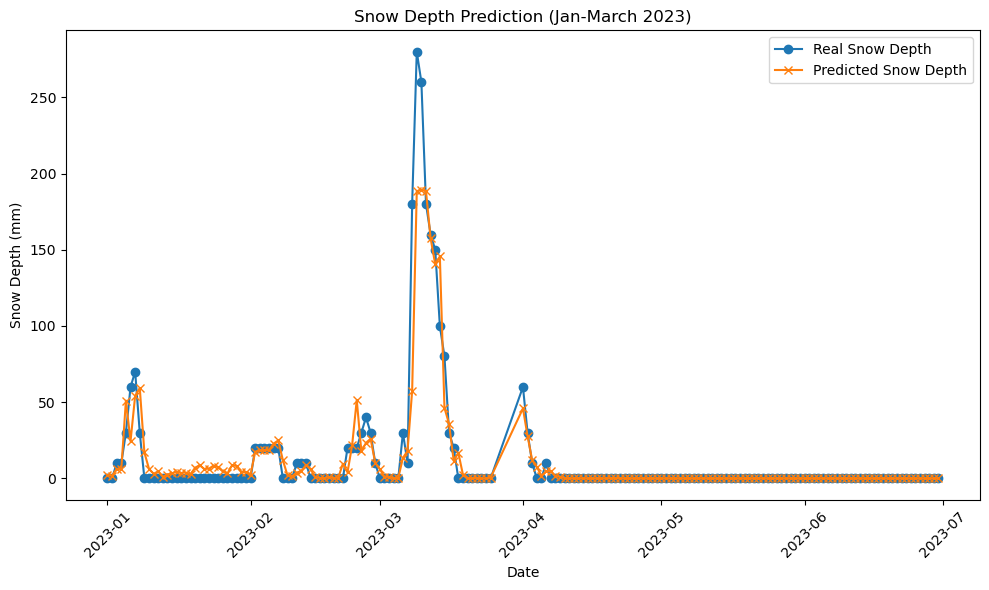

In [57]:
jan_mar_2023 = test_data_snow[(test_data_temp['date'] >= '2023-01-01') & (test_data_temp['date'] <= '2023-12-30')]

# Plot des prédictions et des valeurs réelles de janvier à mars 2023
plt.figure(figsize=(10, 6))
plt.plot(jan_mar_2023['date'], jan_mar_2023['snow_depth_mm'], label='Real Snow Depth', marker='o')
plt.plot(jan_mar_2023['date'], y_pred, label='Predicted Snow Depth', marker='x')
plt.title('Snow Depth Prediction (Jan-March 2023)')
plt.xlabel('Date')
plt.ylabel('Snow Depth (mm)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [59]:
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
0.5*mean_squared_error(y_pred, jan_mar_2023['snow_depth_mm'])

110.82168180412648

In [60]:
mean_absolute_error(y_pred, jan_mar_2023['snow_depth_mm'])

5.041556273935901

# TEMP Prediction using diffrerent models #

In [61]:
param_grid = {
    'n_estimators': [200,250,300,350],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf = RandomForestRegressor(random_state=42)

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

In [62]:
grid_search.fit(X_train_temp, y_train_temp)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


c:\Users\Pierre\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200, 250, 300, 350]},
             scoring='neg_mean_squared_error', verbose=2)

In [63]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)

# Predict using the best model
y_pred = best_model.predict(X_test_temp)

Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 250}


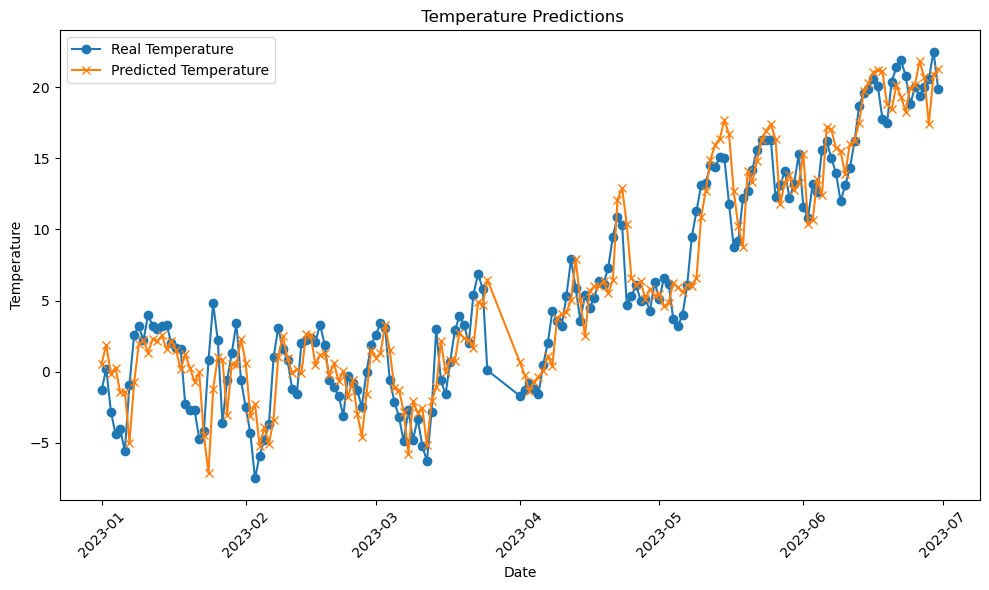

In [64]:
jan_mar_2023 = test_data_snow[(test_data_temp['date'] >= '2023-01-01') & (test_data_temp['date'] <= '2023-12-30')]

# Plot des prédictions et des valeurs réelles de janvier à mars 2023
plt.figure(figsize=(10, 6))
plt.plot(jan_mar_2023['date'], jan_mar_2023['avg_temp_c'], label='Real Temperature', marker='o')
plt.plot(jan_mar_2023['date'], y_pred, label='Predicted Temperature', marker='x')
plt.title(' Temperature Predictions')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

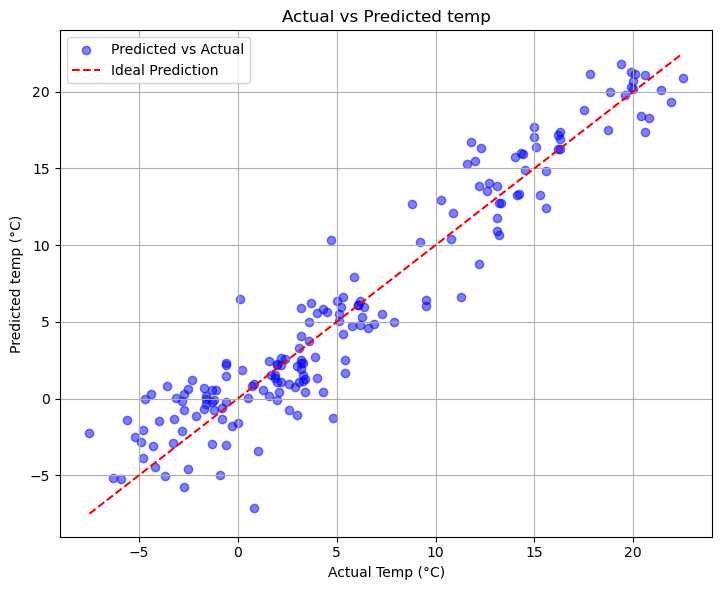

In [65]:
plt.figure(figsize=(14, 6))

# Actual vs Predicted for Temperature
plt.subplot(1, 2, 1)
plt.scatter(jan_mar_2023['avg_temp_c'], y_pred, color='blue', alpha=0.5, label='Predicted vs Actual')
plt.plot([jan_mar_2023['avg_temp_c'].min(), jan_mar_2023['avg_temp_c'].max()], [jan_mar_2023['avg_temp_c'].min(), jan_mar_2023['avg_temp_c'].max()], color='red', linestyle='--', label='Ideal Prediction')
plt.title('Actual vs Predicted temp')
plt.xlabel('Actual Temp (°C)')
plt.ylabel('Predicted temp (°C)')
plt.legend()
plt.grid()



plt.tight_layout()
plt.show()

In [73]:
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
mean_absolute_error(y_pred, jan_mar_2023['avg_temp_c'])

0.34437911054789894

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
X = jan_mar_2023['avg_temp_c'].values.reshape(-1, 1)  # Feature (independent variable)
y = y_pred  # Target (dependent variable)

# Create a LinearRegression model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Calculate the R^2 score
r2 = r2_score(y, y_pred)

print(f"R² score: {r2}")

R² score: 0.9115325456984474


In [79]:
best_rf = grid_search.best_estimator_
feature_importances = best_rf.feature_importances_

# Assuming your features are in a DataFrame X_train_snow, get feature names
# If X_train_snow is a DataFrame, we can get the column names
features = X_train.columns

# Create a DataFrame for better visualization
importances_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the features by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Display the most important features
print(importances_df)

                         Feature  Importance
1               min_temp_c_lag_1    0.674405
2               max_temp_c_lag_1    0.271099
0               avg_wind_dir_deg    0.010196
7               min_temp_c_lag_2    0.004385
13              min_temp_c_lag_3    0.004096
26              max_temp_c_lag_5    0.003342
19              min_temp_c_lag_4    0.003140
14              max_temp_c_lag_3    0.002958
20              max_temp_c_lag_4    0.002870
5   avg_sea_level_pres_hpa_lag_1    0.002469
8               max_temp_c_lag_2    0.002417
4       avg_wind_speed_kmh_lag_1    0.002027
29  avg_sea_level_pres_hpa_lag_5    0.001900
25              min_temp_c_lag_5    0.001621
10      avg_wind_speed_kmh_lag_2    0.001531
22      avg_wind_speed_kmh_lag_4    0.001498
16      avg_wind_speed_kmh_lag_3    0.001415
11  avg_sea_level_pres_hpa_lag_2    0.001190
23  avg_sea_level_pres_hpa_lag_4    0.001097
28      avg_wind_speed_kmh_lag_5    0.001002
17  avg_sea_level_pres_hpa_lag_3    0.000921
21        